In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Assigning to GPU

In [2]:
# Check if GPU is available and set the device accordingly
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(f"Using device: {device}")

## Load Dataset

In [3]:
# Load the dataset
df = pd.read_csv(r"C:\Users\HP\Desktop\DeepLearning_Assignment1_Housing\Housing-1 - Housing-1.csv")

In [4]:
# Display first few rows
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [5]:
df.nunique()

price               219
area                284
bedrooms              6
bathrooms             4
stories               4
mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
parking               4
prefarea              2
furnishingstatus      3
dtype: int64

## Check total count of items and notna and compare
If they are the same then no need to drop na 

In [6]:
df.count()

price               545
area                545
bedrooms            545
bathrooms           545
stories             545
mainroad            545
guestroom           545
basement            545
hotwaterheating     545
airconditioning     545
parking             545
prefarea            545
furnishingstatus    545
dtype: int64

In [7]:
df.notna().sum()

price               545
area                545
bedrooms            545
bathrooms           545
stories             545
mainroad            545
guestroom           545
basement            545
hotwaterheating     545
airconditioning     545
parking             545
prefarea            545
furnishingstatus    545
dtype: int64

## Data Cleaning Process for Outlier Detection

In this code snippet, we perform several steps to clean the dataset by removing outliers based on the target variable, which is the price of a property. Here’s a breakdown of what happens:

1. **Feature and Target Variable Extraction**:
   - We extract the feature (`area`) and the target variable (`price`) from the DataFrame `df`. The feature `X` is reshaped into a 2D array with one column to ensure compatibility with certain machine learning models, while the target variable `y` is retained as a 1D array.

2. **Outlier Detection Using IQR**:
   - We calculate the first (Q1) and third (Q3) quartiles of the target variable `y`. 
   - The Interquartile Range (IQR) is computed as the difference between Q3 and Q1. This IQR helps identify the spread of the middle 50% of the data.
   - Using the IQR, we set lower and upper bounds for outlier detection: any data point falling below the lower bound (`Q1 - 1.5 * IQR`) or above the upper bound (`Q3 + 1.5 * IQR`) is considered an outlier.

3. **Cleaning the Dataset**:
   - The dataset is filtered to remove outliers, resulting in a new DataFrame (`data_clean`) that contains only rows where the `price` falls within the calculated bounds.
   - Finally, we update the feature (`X`) and target variable (`y`) to reflect this cleaned dataset, ensuring that subsequent analyses or modeling efforts are not skewed by outlier values.





In [8]:
# Convert the 'area' column from the DataFrame into a NumPy array
# Reshape it into a 2D array with one column, which is often required for compatibility with certain machine learning models
X = np.array(df['area']).reshape(-1, 1)

# The target variable (y) is the 'price' column, which we want to predict.
# Here, we simply convert it into a NumPy array without reshaping, as it's a 1D array.
y = np.array(df['price']) 

# Calculate the first quartile (Q1) of the target variable 'price'
Q1 = np.percentile(y, 25)

# Calculate the third quartile (Q3) of the target variable 'price'
Q3 = np.percentile(y, 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1  # The IQR represents the range between Q1 and Q3

# Determine the lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR  # Lower bound for outlier detection
upper_bound = Q3 + 1.5 * IQR  # Upper bound for outlier detection

# Clean the dataset by filtering out rows where the 'price' is an outlier
# Only include rows where 'price' is between the lower and upper bounds
data_clean = df[(y >= lower_bound) & (y <= upper_bound)][['area', 'price']]

# Update X and y with the cleaned data
X = np.array(data_clean['area']).reshape(-1, 1)  # Reassign X with the cleaned 'area' data
y = np.array(data_clean['price'])  # Reassign y with the cleaned 'price' data

data_clean

,area,price
15,6000,9100000
16,6600,9100000
17,8500,8960000
18,4600,8890000
19,6420,8855000
...,...,...
540,3000,1820000
541,2400,1767150
542,3620,1750000
543,2910,1750000


In [9]:
# Train-test split: 60% train , 40% val + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Train-test split: 20% val, 20% test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)

In [10]:
# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(1)

# Implementing a neural network for regression

In [11]:
# Neural network model
class HousingModel(nn.Module):
    def __init__(self, input_size):
        super(HousingModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Training and Validation for Model Evaluation


In [12]:
# Define parameters and instantiate model
epochs=10000
model = HousingModel(input_size=1)
criterion = nn.MSELoss()  # Use MSE for regression
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [13]:
# Training loop
losses = []
val_losses = []  # To track validation losses
for epoch in range(epochs):
    # --- Training Phase ---
    model.train()  # Set model to training mode
    
    # Forward pass
    y_pred = model(X_train)  # Training prediction

    # Compute the loss
    loss = criterion(y_pred, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track training loss
    losses.append(loss.item())

    # --- Validation Phase ---
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        y_val_pred = model(X_val)  # Validation prediction
        val_loss = criterion(y_val_pred, y_val)  # Validation loss

        # Track validation loss
        val_losses.append(val_loss.item())

    # Print the results every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Train Loss: {loss.item():.4f}, '
              f'Val Loss: {val_loss.item():.4f}')

Epoch [100/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [200/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [300/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [400/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [500/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [600/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [700/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [800/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [900/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [1000/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [1100/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [1200/10000], Train Loss: 1486313619456.0000, Val Loss: 2509840580608.0000
Epoch [1300/10000], Train Loss: 14863

## Model Evaluation with No Gradient Calculation

The following code evaluates the performance of a trained model on the test dataset by computing common regression metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), and the R-squared (R²) score.


In [14]:
# Evaluation with no gradient calculation
with torch.no_grad():
    y_pred_test = model(X_test)
    # Compute the metrics
    mse = mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    # Print the results
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")


Mean Squared Error (MSE): 2460670230528.0000
Mean Absolute Error (MAE): 1190378.5000
R-squared (R2): 0.2202


# Model Testing Function

In [15]:
# Evaluate the model on the test set
with torch.no_grad():
    y_pred_test = model(X_test)
    test_loss = criterion(y_pred_test, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 2460670230528.0000


## Plotting the Regression Line and Data Points

The following code visualizes the relationship between the test data and the model's predictions by plotting both the actual data points and the predicted regression line:


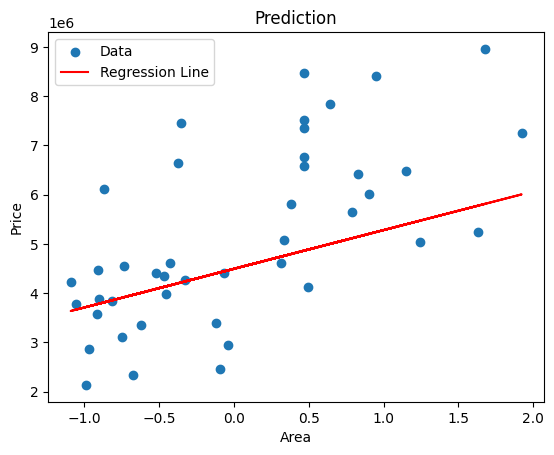

In [16]:
# Scatter plot of the test data
plt.scatter(X_test, y_test, label='Data')  # Plot actual test data points (area vs price) using scatter plot

# Plot the predicted regression line (model predictions for X_test)
plt.plot(X_test, y_pred_test, color='red', label='Regression Line')  # Plot predicted line based on model output

# Set the x-axis label
plt.xlabel('Area')  # Label for the x-axis, representing the "Area" feature

# Set the y-axis label
plt.ylabel('Price')  # Label for the y-axis, representing the "Price" target

# Set the plot title
plt.title('Prediction')  # Add a title to the plot to describe it

# Add a legend to distinguish between the actual data and the regression line
plt.legend()  # Displays the legend to show which plot is data and which is the regression line

# Display the plot
plt.show()  # Show the plot with both the scatter points and regression line


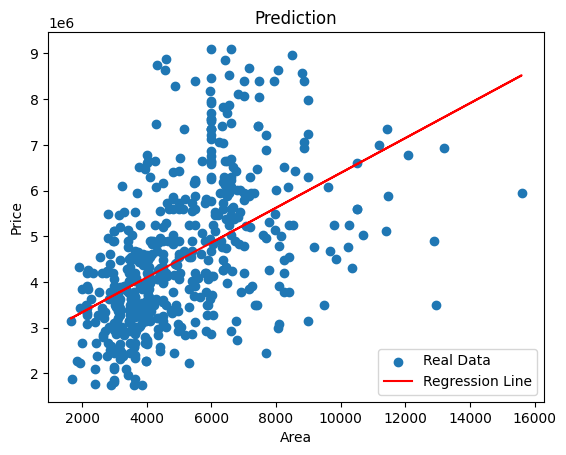

In [17]:
with torch.no_grad():  # Disable gradient tracking (not needed for predictions)
    # Use the scaler to transform the entire input dataset (X)
    input_scaled = scaler.transform(X)  # Scale the input features using the same scaler used for training

    # Convert the scaled input data from NumPy array to PyTorch tensor
    X_all = torch.from_numpy(input_scaled).float()  # Convert to PyTorch tensor (as float32)

    # Make predictions on the entire dataset using the model
    y_pred_all = model(X_all)  # Model makes predictions based on the input data

# Plot the real data points using a scatter plot
plt.scatter(X, y, label='Real Data')  # Scatter plot of actual data (X vs. y)

# Plot the predicted values (from the model) as a regression line
plt.plot(X, y_pred_all.numpy(), color='red', label='Regression Line')  # Convert predictions to NumPy and plot the regression line

# Set the x-axis label
plt.xlabel('Area')  # Label for x-axis representing the "Area" feature

# Set the y-axis label
plt.ylabel('Price')  # Label for y-axis representing the "Price" target

# Set the title of the plot
plt.title('Prediction')  # Title of the plot indicating it's a prediction visualization

# Add a legend to distinguish between real data and the regression line
plt.legend()  # Display legend to differentiate between the scatter data and regression line

# Show the plot
plt.show()  # Render the plot with both the scatter points and the regression line
